In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
Z_DIM = 6
OUT_DIM = 4
REAL_LABEL = 1
FAKE_LABEL = 0
n_epoch = 25
lr = 6e-4
batch_size = 64

d_lr = 1e-3
g_lr = 1e-4

seed = 42

name = "classical-gan-1.5.4"

save_folder = f"saved/{name}"

data_path = "dataset/dataset.npy"

In [3]:
## some code to prevent the the output from being saved to the wrong directory

if globals().get("__file__") and os.path.basename(globals["__file__"]) != name + ".py":
    raise UserWarning("The 'name' variable does not match the file name.")
if globals().get("__vsc_ipynb_file__") and os.path.basename(globals().get("__vsc_ipynb_file__")) != name + ".ipynb":
    raise UserWarning("The 'name' variable does not match the file name.")

In [4]:
if os.path.exists(save_folder):
    print(f"This notebook may overwrite previous results in the {save_folder} directory")
else:
    os.makedirs(save_folder)

rng = np.random.default_rng()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# torch.manual_seed(seed)
# torch.use_deterministic_algorithms(True) 

In [5]:
np.load(data_path)

array([[0.22623759, 0.89513221, 0.38569896, 0.36755241],
       [0.2104556 , 0.99467451, 0.01770609, 0.46760388],
       [0.13881856, 0.87695348, 0.2597558 , 0.31825066],
       ...,
       [0.93326431, 0.30004156, 0.68643019, 0.16775284],
       [0.57852725, 0.38947711, 0.64027193, 0.96771737],
       [0.96939843, 0.80032157, 0.09973308, 0.38007525]])

In [6]:
data_true = np.load(data_path)
rng.shuffle(data_true)
data_true = torch.tensor(data_true, dtype = torch.float32, device=device, requires_grad=False)
data_loader = torch.utils.data.DataLoader(data_true, batch_size=batch_size, shuffle = True)

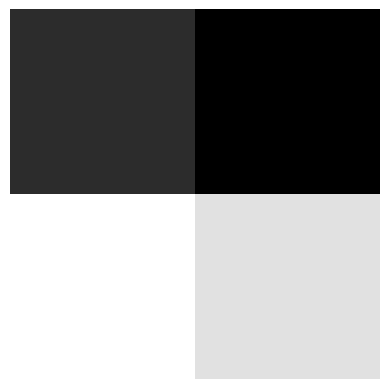

In [7]:
real_batch = next(iter(data_loader))
real_sample_one = real_batch[0]
plt.figure()
plt.axis("off")
plt.imshow(real_sample_one.reshape(2, 2).cpu(), cmap="binary")

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.5)
        m.bias.data.uniform_(-0.3, 0.3)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(Z_DIM, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 12),
            nn.LeakyReLU(0.2),
            nn.Linear(12, OUT_DIM),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 12),
            nn.LeakyReLU(0.2),
            # nn.Linear(16, 8),
            # nn.LeakyReLU(0.2),
            nn.Linear(12, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=8, out_features=12, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=12, out_features=4, bias=True)
    (5): Sigmoid()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(0.5, 0.999))

In [13]:
for param in netD.parameters():
    print(param.data)

tensor([[ 0.2125,  0.2350, -0.8692, -0.5760],
        [-0.1883, -0.0594, -0.8791,  0.4949],
        [ 0.3622, -0.1512,  0.1006, -0.0725],
        [ 0.4928,  1.1745, -0.3439,  0.0320],
        [-0.0455,  0.2067,  0.1322, -0.4545],
        [ 0.6153,  0.4119,  0.1774, -0.6699],
        [-0.1039, -0.6095,  0.5448, -0.8508],
        [-0.0288, -0.0015, -0.3333,  0.1358],
        [-0.4252,  0.0746,  0.8053, -0.9123],
        [ 0.4296,  0.0323, -0.1388, -0.8967],
        [-0.3828, -0.0320, -0.1307,  0.7439],
        [ 0.3664,  0.7983,  0.3367,  0.2143]], device='cuda:0')
tensor([ 0.0591,  0.1216, -0.2635,  0.2766, -0.2682, -0.2482,  0.1608,  0.2722,
        -0.1509, -0.2614,  0.2733,  0.2297], device='cuda:0')
tensor([[-0.5541, -0.2143, -0.9099, -1.0467, -0.4468,  0.5138, -0.8539, -0.1616,
         -0.5539, -0.2499,  0.0805, -0.0107],
        [-1.3503,  0.0419, -0.0395, -0.5001,  0.1900, -0.0621, -0.0975,  0.1332,
         -0.2971, -0.4105,  0.8563, -0.1956],
        [-0.2177,  0.1275,  0.8432

In [14]:
for param in netG.parameters():
    print(param.data)

tensor([[-0.1052,  0.0216, -0.3182,  0.1342,  1.3886,  0.9929],
        [-0.4872,  0.2703, -0.2967,  0.2381, -0.2622, -0.5224],
        [ 0.7131, -0.3489, -0.4542, -1.0387,  0.4745, -0.2633],
        [-0.3517,  0.4432, -0.5600,  0.3707, -0.0689, -0.8065],
        [-0.5539,  0.1533, -0.4450,  0.0691, -1.0241, -0.2697],
        [ 0.5281, -0.1584,  0.1479,  0.6141,  0.1617,  0.1150],
        [ 0.3207, -0.6541,  0.5886,  1.0433, -0.0274,  0.3372],
        [-0.5144, -0.0231, -0.7704,  0.6874, -0.9104, -0.2715]],
       device='cuda:0')
tensor([-0.0883,  0.2551, -0.1654,  0.1576,  0.0971,  0.1398, -0.1317, -0.2877],
       device='cuda:0')
tensor([[-8.1243e-01,  5.8952e-01,  3.3573e-02,  8.4036e-01,  5.1096e-01,
         -7.3421e-01, -5.7357e-01,  4.6044e-01],
        [-5.0625e-01, -2.5232e-01,  8.8212e-02,  1.6846e-01, -2.3704e-01,
          8.0324e-02, -1.6653e-02, -5.9489e-01],
        [-3.9396e-01,  3.3001e-02, -3.6175e-01, -7.2264e-01,  3.5594e-01,
         -2.2980e-01, -7.8493e-01,  4.

In [15]:
G_losses = []
D_losses = []
iters = 0

netD.train()
netG.train()

print("Starting Training Loop...")

for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):

        netD.zero_grad()
        real_batch = data.to(device)
        b_size = real_batch.shape[0]
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        output = netD(real_batch).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, Z_DIM, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(REAL_LABEL)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if i % 50 == 0:
            print(f"[{epoch}/{n_epoch}][{i}/{len(data_loader)}]\tLossD: {errD.item():.4f}\tLossG: {errG.item():.4f}\t" +
                f"D(x): {D_x:.4f}\tD(G(x)): {D_G_z2:.4f}")



Starting Training Loop...
[0/25][0/320]	LossD: 2.0675	LossG: 1.5928	D(x): 0.1802	D(G(x)): 0.2255
[0/25][50/320]	LossD: 1.3612	LossG: 1.1160	D(x): 0.4168	D(G(x)): 0.3454
[0/25][100/320]	LossD: 1.0709	LossG: 0.9947	D(x): 0.5719	D(G(x)): 0.3817
[0/25][150/320]	LossD: 0.9495	LossG: 1.0929	D(x): 0.6142	D(G(x)): 0.3479
[0/25][200/320]	LossD: 0.7936	LossG: 1.1535	D(x): 0.7158	D(G(x)): 0.3368
[0/25][250/320]	LossD: 0.8681	LossG: 1.1498	D(x): 0.6769	D(G(x)): 0.3374
[0/25][300/320]	LossD: 0.8500	LossG: 1.4259	D(x): 0.6641	D(G(x)): 0.2874
[1/25][0/320]	LossD: 0.8625	LossG: 1.3060	D(x): 0.7014	D(G(x)): 0.3166
[1/25][50/320]	LossD: 0.7212	LossG: 1.4530	D(x): 0.7343	D(G(x)): 0.2829
[1/25][100/320]	LossD: 0.7249	LossG: 1.4857	D(x): 0.7415	D(G(x)): 0.2804
[1/25][150/320]	LossD: 0.8711	LossG: 1.3581	D(x): 0.6955	D(G(x)): 0.3159
[1/25][200/320]	LossD: 0.8903	LossG: 1.5444	D(x): 0.6427	D(G(x)): 0.2593
[1/25][250/320]	LossD: 1.0044	LossG: 1.3013	D(x): 0.6470	D(G(x)): 0.3348
[1/25][300/320]	LossD: 0.9361	L

In [16]:
for param in netD.parameters():
    print(param.data)

tensor([[ 0.3910,  0.0113, -0.1009, -1.3494],
        [-0.6748, -0.3220, -2.1123, -0.2017],
        [ 0.7639,  0.1549,  0.3309,  0.0023],
        [ 1.0003,  0.9942, -0.2666,  0.2893],
        [ 0.4037,  0.3123,  0.7810, -0.1111],
        [ 0.5247,  0.3335,  0.9164, -0.0157],
        [ 0.2017,  0.0188, -0.0533, -1.4992],
        [-0.2318,  0.4158, -0.3581,  0.1797],
        [-1.2597, -0.0660,  0.9624,  0.0761],
        [ 0.9327, -0.2166,  0.0555, -0.5671],
        [-0.7124,  0.0207, -0.4242,  0.6942],
        [ 1.5218,  0.6933,  0.9438,  0.9380]], device='cuda:0')
tensor([ 0.4354,  0.0585, -0.7464,  0.2303,  0.0044, -0.8186,  0.7991,  0.5796,
         1.0853, -0.7879,  0.3479,  0.1861], device='cuda:0')
tensor([[-1.3054, -0.6691, -2.4838, -1.1677,  0.0609,  0.9270,  0.0875, -0.3887,
         -0.7769, -0.2328,  0.0974,  0.0423],
        [-1.6467,  0.1589, -1.5066, -0.3711,  0.8402,  0.4842,  0.8232,  0.5211,
          0.0807, -0.7282,  1.1313, -0.2273],
        [ 0.2912,  0.2252,  1.9606

In [17]:
for param in netG.parameters():
    print(param.data)

tensor([[-0.0279, -0.1099, -0.2201,  0.2775,  1.1852,  0.7773],
        [-0.5889, -0.0923, -0.6672,  0.2586, -0.0826, -0.5583],
        [ 0.9270, -0.6807, -0.3718, -1.0299,  0.7101, -0.1408],
        [-0.2435,  0.5152, -0.2029,  0.5081, -0.0715, -0.6094],
        [-0.4564,  0.1896, -0.2452,  0.2458, -0.8364,  0.0360],
        [ 0.4193, -0.2141,  0.1195,  0.5241,  0.2342,  0.1462],
        [ 0.5181, -0.7592,  0.3162,  1.0462,  0.2754,  0.2685],
        [-0.6156, -0.0630, -0.6205,  0.7284, -0.9212, -0.2515]],
       device='cuda:0')
tensor([-0.3608,  0.3750,  0.0931,  0.5400,  0.0091,  0.0872, -0.1016, -0.3618],
       device='cuda:0')
tensor([[-0.6830,  0.4600,  0.1240,  0.6354,  0.3368, -0.6428, -0.4996,  0.2372],
        [-0.4146, -0.1043,  0.3874,  0.1510, -0.3549,  0.2100,  0.1616, -0.8972],
        [-0.6152, -0.2098, -0.8348, -0.7838,  0.1426, -0.3700, -1.0490,  0.3562],
        [ 0.2525,  0.5254,  0.0718, -0.9203, -0.4104, -0.5139, -0.1173,  0.7304],
        [ 0.1664, -0.1688, -0.

In [18]:
netD.eval()
netG.eval()

Generator(
  (main): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=8, out_features=12, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=12, out_features=4, bias=True)
    (5): Sigmoid()
  )
)

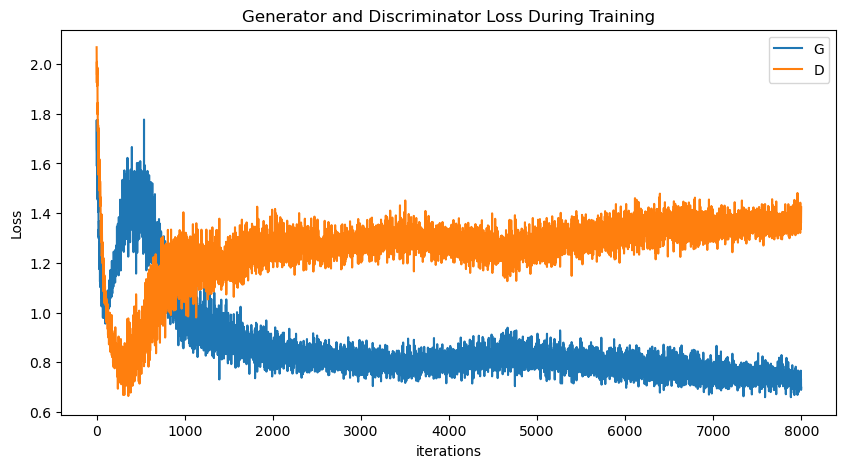

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
n_rows = 4
n_cols = 4

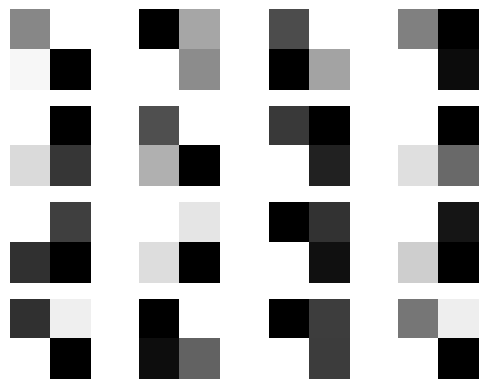

In [21]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")

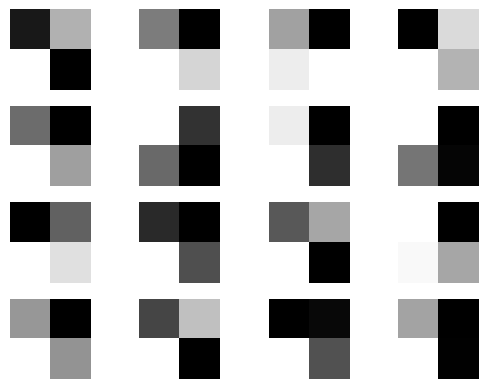

In [22]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")

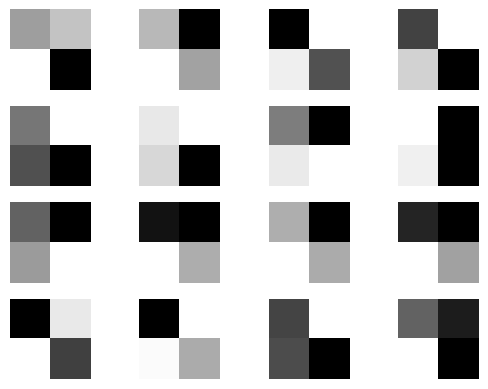

In [23]:
b_size = n_rows * n_cols

noise = torch.randn(b_size, Z_DIM, device=device)

with torch.no_grad():
    fake_batch = netG(noise)

fig, axes = plt.subplots(n_rows, n_cols)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(fake_batch[i].reshape(2, 2).cpu(), cmap="binary")

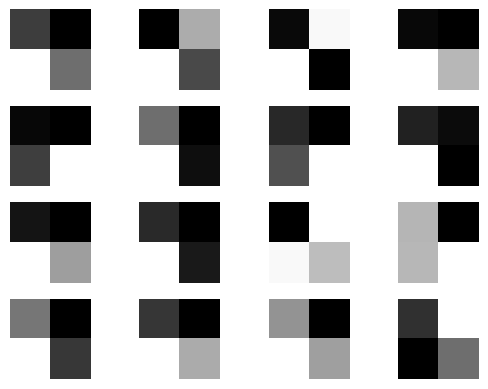

In [24]:
b_size = n_rows * n_cols

noise = torch.randn(b_size, Z_DIM, device=device)

with torch.no_grad():
    fake_batch = netG(noise)

fig, axes = plt.subplots(n_rows, n_cols)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(fake_batch[i].reshape(2, 2).cpu(), cmap="binary")

In [25]:
sample_size = 10000
data_index = torch.randperm(data_true.shape[0])[:sample_size]
real_samples = data_true[data_index]



noise = torch.randn(sample_size, Z_DIM, device=device)
with torch.no_grad():
    fake_samples = netG(noise)


np.savez(save_folder + "/samples.npz", 
    real_samples = real_samples.cpu(), 
    fake_samples_raw=fake_samples.cpu())

In [26]:
with torch.no_grad():
    real_scores = netD(real_samples).cpu()
    fake_scores = netD(fake_samples).cpu()
    # fake_rounded_scores = netD(fake_samples_rounded).cpu()

In [27]:
print(np.mean(real_scores.numpy()))
print(np.mean(fake_scores.numpy()))
# print(np.mean(fake_rounded_scores.numpy()))

0.5193862
0.49721718


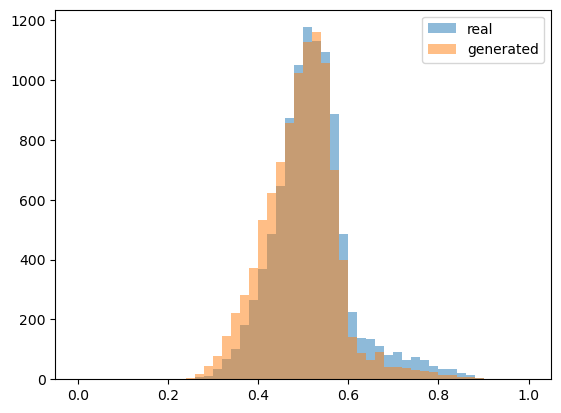

In [28]:
fig, ax = plt.subplots()



ax.hist(real_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha = 0.5, label="real")
ax.hist(fake_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha = 0.5, label="generated")

ax.legend()

None

In [29]:
# fig, ax = plt.subplots()



# ax.hist(real_scores.view(-1), bins = 50, range=(0, 1), alpha=0.5, color = plt.cm.tab10(0))
# ax.hist(fake_rounded_scores.view(-1), bins = 50, range=(0, 1), alpha=0.5, color = plt.cm.tab10(1))

# None

In [30]:
# json_path = data_path[:-4] + ".json"
# with open(json_path, 'r') as f:
#     real_data_dict = json.load(f)

# def np_to_dict(result_np):
#     result_dict = {}
#     for line in result_np:
#         str_key = ""
#         for i in line:  # reversing the order to match qiskit notation
#             str_key+=(str(i))
#         current_value = result_dict.get(str_key, 0)
#         result_dict[str_key] = current_value + 1
#     return result_dict

# noise = torch.randn(20480, Z_DIM, device=device)
# with torch.no_grad():
#     fake_data = netG(noise)
# # fake_data_rounded = torch.round(fake_data_raw)
# # fake_data_rounded = fake_data_rounded.cpu().numpy().astype(np.int32)


# fake_data_dict = np_to_dict(fake_data_rounded)

# all_keys = (set(real_data_dict.keys())) | (set(fake_data_dict.keys()))

# real_counts = []
# fake_counts = []

# for k in all_keys:
#     real_counts.append(real_data_dict.get(k, 0))
#     fake_counts.append(fake_data_dict.get(k, 0))

# real_counts = np.array(real_counts)
# fake_counts = np.array(fake_counts)

# real_probs = real_counts / np.sum(real_counts)
# fake_probs = fake_counts / np.sum(fake_counts)

# mixed_probs = (real_probs + fake_probs) / 2 # here, every entry of mixed_probs are positive

# # Note, mixed_probs is all positive. That's why you can use nan_to_num to deal with zero entries in real_probs or fake_probs
# dl_r = np.sum(real_probs * np.nan_to_num(np.log(real_probs / mixed_probs)))
# dl_f = np.sum(fake_probs * np.nan_to_num(np.log(fake_probs / mixed_probs)))

# jl_div = (dl_r + dl_f) / 2

# print(f"JL-divergens is {jl_div}")


In [31]:
# train a standalone discriminator to evaluate the performance of the GAN "objectively"
class Evaluator(nn.Module):
    def __init__(self):
        super(Evaluator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 16),
            # nn.LeakyReLU(0.2),
            # nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [32]:
netEv = Evaluator().to(device)
netEv.apply(weights_init)

optimizer_ev = optim.Adam(netEv.parameters(), lr=lr, betas=(0.5, 0.999))
loss_ev = nn.BCELoss()
print(netEv)

Evaluator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [33]:
batch_size_ev = 16

In [34]:
real_samples_np = real_samples.cpu().numpy()
fake_samples_np = fake_samples.cpu().numpy()

samples = np.concatenate((real_samples_np, fake_samples_np))

real_labels = np.repeat(REAL_LABEL, real_samples_np.shape[0])
fake_labels = np.repeat(FAKE_LABEL, fake_samples_np.shape[0])
labels = np.concatenate((real_labels, fake_labels))

X_train, X_rest, y_train, y_rest = train_test_split(
    samples, labels, train_size = 0.6, shuffle = True, stratify = labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rest, y_rest, test_size = 0.5, shuffle = True, stratify = y_rest
)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
y_valid = torch.tensor(y_valid, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)


data_loader_ev = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size = batch_size_ev, shuffle = True)


In [35]:
valid_losses = []
train_losses = []
iters = 0

netEv.train()
 

print("Starting the training loop")
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader_ev):
        netEv.zero_grad()
        X_batch = data[0].to(device)
        y_batch = data[1].to(device)
        prediction_batch = netEv(X_batch).view(-1)
        err = loss_ev(prediction_batch, y_batch)
        err.backward()
        optimizer_ev.step()

        if i%50 == 0:
            netEv.eval()
            with torch.no_grad():
                prediction_valid = netEv(X_valid).view(-1)
                prediction_train = netEv(X_train).view(-1)
            train_loss = loss_ev(prediction_train, y_train).item()
            valid_loss = loss_ev(prediction_valid, y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_acc  = torch.isclose(torch.round(prediction_valid), y_valid).sum().item()/len(y_valid)
            netEv.train()

            print(
                f"[{epoch}/{n_epoch}][{i}/{len(data_loader)}]\tLoss train: {train_loss:.3f}\tLoss valid: {valid_loss:.3f}\tLoss acc: {valid_acc:.3f}"
            )

Starting the training loop
[0/25][0/320]	Loss train: 0.776	Loss valid: 0.772	Loss acc: 0.500
[0/25][50/320]	Loss train: 0.722	Loss valid: 0.720	Loss acc: 0.500
[0/25][100/320]	Loss train: 0.701	Loss valid: 0.700	Loss acc: 0.495
[0/25][150/320]	Loss train: 0.697	Loss valid: 0.696	Loss acc: 0.494
[0/25][200/320]	Loss train: 0.695	Loss valid: 0.694	Loss acc: 0.520
[0/25][250/320]	Loss train: 0.694	Loss valid: 0.694	Loss acc: 0.511
[0/25][300/320]	Loss train: 0.694	Loss valid: 0.694	Loss acc: 0.505
[0/25][350/320]	Loss train: 0.694	Loss valid: 0.694	Loss acc: 0.523
[0/25][400/320]	Loss train: 0.694	Loss valid: 0.693	Loss acc: 0.514
[0/25][450/320]	Loss train: 0.694	Loss valid: 0.693	Loss acc: 0.501
[0/25][500/320]	Loss train: 0.694	Loss valid: 0.693	Loss acc: 0.499
[0/25][550/320]	Loss train: 0.694	Loss valid: 0.694	Loss acc: 0.491
[0/25][600/320]	Loss train: 0.694	Loss valid: 0.693	Loss acc: 0.498
[0/25][650/320]	Loss train: 0.693	Loss valid: 0.693	Loss acc: 0.492
[0/25][700/320]	Loss tra

In [36]:
X_batch

tensor([[0.5706, 0.0133, 0.1690, 0.5849],
        [0.5357, 0.5482, 0.0158, 0.7075],
        [0.5741, 0.2495, 0.1670, 0.3207],
        [0.7872, 0.5248, 0.0495, 0.1931],
        [0.8435, 0.0578, 0.0928, 0.5890],
        [0.4729, 0.9195, 0.1632, 0.9527],
        [0.5579, 0.9813, 0.6368, 0.7950],
        [0.4444, 0.7580, 0.1170, 0.2294],
        [0.7182, 0.9995, 0.8861, 0.9078],
        [0.4320, 0.7923, 0.1786, 0.7092],
        [0.8690, 0.3992, 0.1010, 0.7635],
        [0.6315, 0.8795, 0.0884, 0.2108],
        [0.7418, 0.9751, 0.0760, 0.9447],
        [0.6508, 0.8272, 0.1459, 0.2387],
        [0.6882, 0.0144, 0.0268, 0.2867],
        [0.8179, 0.2036, 0.1343, 0.3413]], device='cuda:0')

In [37]:
X_batch.shape

torch.Size([16, 4])

In [38]:
prediction_batch

tensor([0.3283, 0.5139, 0.5032, 0.5534, 0.2733, 0.3913, 0.5698, 0.5286, 0.6799,
        0.4398, 0.4513, 0.6157, 0.4123, 0.5189, 0.3223, 0.3853],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [39]:
y_batch

tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
       device='cuda:0')

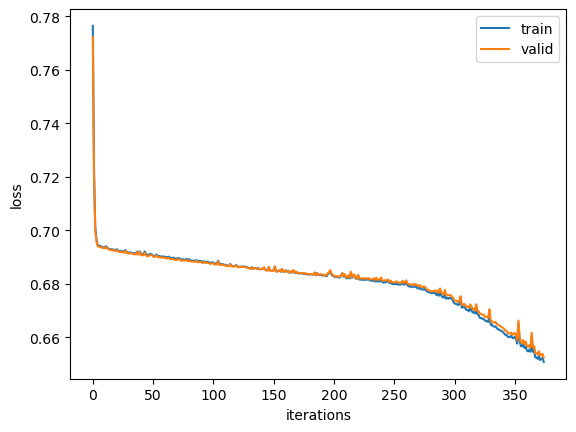

In [40]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

In [41]:
netEv.eval()

with torch.no_grad():
    prediction_test = netEv(X_test).view(-1)

test_acc = torch.isclose(torch.round(prediction_test), y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.6275


In [42]:
print(f"AUC score is {roc_auc_score(y_test.cpu(), prediction_test.cpu())}")

AUC score is 0.6807425


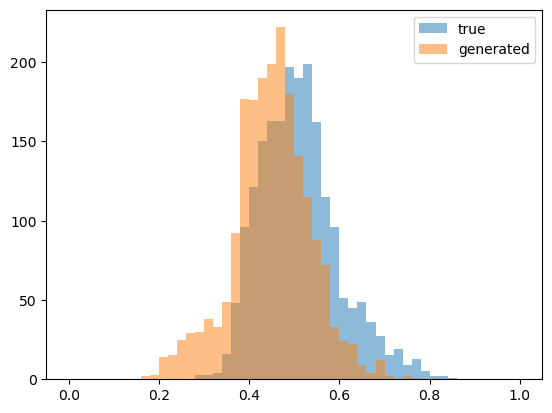

In [43]:
true_indices = y_test.isclose(torch.tensor(1.0))
fake_indices = y_test.isclose(torch.tensor(0.0))

pred_true = prediction_test[true_indices]
pred_fake = prediction_test[fake_indices]

fig, ax = plt.subplots()
ax.hist(pred_true.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="true")
ax.hist(pred_fake.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")
ax.legend()

None